In [23]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
from seaborn import *

In [24]:
env = gym.make('FrozenLake8x8-v0')

n_state = env.nS
n_action = env.nA

print(n_state)
print(n_action)

64
4


In [25]:
def plot_graph(param, curves, param_name="", curve_name=""):
    colors = ['deepskyblue', 'red', 'yellow', 'green', 'midnightblue', 'fuchsia']
    plt.figure()
    lines = []
    l, = plt.plot(param, curves, ls='-', marker='+', color='deepskyblue')
    lines.append(l)
    plt.xlabel(param_name)
    plt.ylabel(curve_name)
    
    plt.show()

In [26]:
def plot_graphs(param, curves, curve_labels, param_name="", curve_name=""):
    colors = ['firebrick', 'cadetblue', 'darksalmon', 'mediumseagreen', 'darkmagenta', 'skyblue', 
              'gold','palevioletred', 'olive', 'darkorange', 'mediumpurple', 'slategray', 'darkseagreen']
    plt.figure()
    lines = []
    for i in range(len(curve_labels)):
        l, = plt.plot(param, curves[i,:], ls='-', marker='', color=colors[i])
        lines.append(l)
    plt.xlabel(param_name)
    plt.ylabel(curve_name)
    
    plt.legend(handles=lines, labels=curve_labels, loc='best')
    plt.show()

Value Iteration

In [27]:
def eval_state_action(state_value, s, a, gamma=0.9):
    return np.sum([prob * (reward + gamma * state_value[next_state]) for prob, next_state, reward, _ in env.P[s][a] ])

In [28]:
def check_convergence(state_value, new_state_value, delta_state, eps, algo):
    if algo == 0:
        if abs(sum(state_value) - sum(new_state_value)) < eps:
            state_value = state_value
        else:
            state_value = new_state_value.copy()

    elif algo == 1:
        for d in range(n_state):
            converged = True
            if delta_state[d] > eps:
                converged = False
        if converged:
            state_value = state_value
        else :
            state_value = new_state_value.copy()
    return state_value

In [29]:
def value_one_iteration(state_value, gamma=0.9, eps=0.0001, conv=0):
    new_state_value = state_value.copy()
    
    delta_state = np.zeros(n_state)
    converged = False
    
    for state in range(n_state):
        all_a_values = []
        for action in range(n_action):
            tmp_st_val = eval_state_action(state_value, state, action, gamma)
            all_a_values.append(tmp_st_val)
        best_a = np.argmax(np.asarray(all_a_values))
        new_state_value[state] = all_a_values[best_a]
            
        delta_state[state] = np.abs(new_state_value[state] - state_value[state])

    state_value = check_convergence(state_value, new_state_value, 
                                    delta_state, eps, algo=conv)
    
    return state_value

In [30]:
def value_iteration(max_iterations=100000, gamma=0.9, eps=0.0001, conv=0):
    state_value = np.zeros(n_state)
    new_state_value = state_value.copy()
    
    delta_state = np.zeros(n_state)
    converged = False
    it_converged = 0
    conv_time = 0
    
    start_time = time.time()
    
    for i in range(max_iterations):
        for state in range(n_state):
            all_a_values = []
            for action in range(n_action):
                tmp_st_val = eval_state_action(state_value, state, action, gamma)
                all_a_values.append(tmp_st_val)
            best_a = np.argmax(np.asarray(all_a_values))
            new_state_value[state] = all_a_values[best_a]
            
            delta_state[state] = np.abs(new_state_value[state] - state_value[state])

        if conv == 0:
            if abs(sum(state_value) - sum(new_state_value)) < eps:
                conv_time = time.time() - start_time
                it_converged = i+1
                break
            else:
                state_value = new_state_value.copy()
        elif conv == 1:
            converged = True
            for d in range(n_state):
                if delta_state[d] > eps:
                    converged = False
            if converged:
                it_converged = i+1
                conv_time = time.time() - start_time
                break
            else :
                state_value = new_state_value.copy()
    
    print("max iter:", max_iterations, "gamma:", gamma, ", conv iter:", it_converged, ", conv time:", conv_time)
    return state_value

In [31]:
def get_policy(state_value, gamma=0.9):
    policy = np.zeros(n_state)
    
    for state in range(n_state):
        all_a_values = []
        for action in range(n_action):
            tmp_st_val = eval_state_action(state_value, state, action, gamma)
            all_a_values.append(tmp_st_val)
        best_a = np.argmax(np.asarray(all_a_values))
        policy[state] = best_a
    
    return policy

In [32]:
def get_scores(policy, episodes=1000):
    misses = 0
    steps_list = []
    
    for episode in range(episodes):
        observation = env.reset()
        steps = 0
        while True:
            action = policy[observation]
            observation, reward, done, info = env.step(action)
            steps += 1
            if done and reward == 1:
                steps_list.append(steps)
                break
            elif done and reward == 0:
                misses += 1
                break
    mean_steps = np.mean(steps_list)
    per_misses = (misses/episodes) * 100
    return mean_steps, per_misses

In [33]:
def run_iterations(gamma, eps, max_iter):
    iterations = np.arange(1, max_iter+1)
    
    state_values = np.zeros(n_state)
    tot_V = []
    
    for i in iterations:
        state_values = value_one_iteration(state_values, gamma=gamma, eps=eps, conv=0)
        tot_V.append(np.sum(state_values, axis=0))
    
    return tot_V

In [34]:
max_iterations_gamma = 60
gamma_list = np.arange(0.1, 1.1, 0.1)
tot_V_gammas = np.zeros((len(gamma_list), max_iterations_gamma))
i = 0
for g in gamma_list:
    tot_V_gammas[i,:] = run_iterations(gamma=g, eps=0.0001, max_iter=max_iterations_gamma)
    i += 1

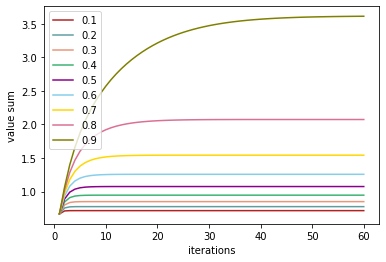

In [35]:
plot_graphs(range(1, max_iterations_gamma+1), tot_V_gammas, 
            ["0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9"], 
            param_name="iterations", curve_name="value sum")

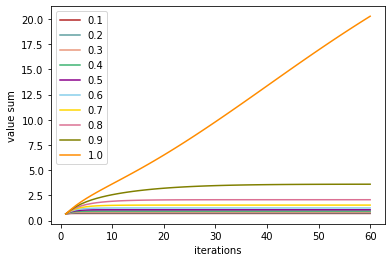

In [36]:
plot_graphs(range(1,max_iterations_gamma+1), tot_V_gammas, 
            ["0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9","1.0"], 
            param_name="iterations", curve_name="value sum")

In [37]:
max_iterations_epsilon = 50
epsilon_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
tot_V_eps = np.zeros((len(epsilon_list), max_iterations_epsilon))
i = 0
for e in epsilon_list:
    tot_V_eps[i,:] = run_iterations(gamma=0.9, eps=e, max_iter=max_iterations_epsilon)
    i += 1

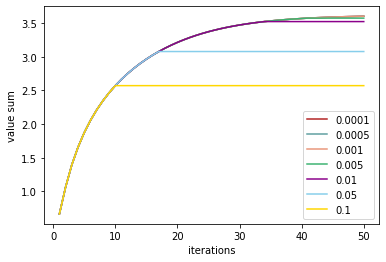

In [38]:
plot_graphs(range(1, max_iterations_epsilon+1), tot_V_eps, 
            ["0.0001","0.0005","0.001","0.005","0.01","0.05","0.1"], 
            param_name="iterations", curve_name="value sum")

In [39]:
vi_gamma_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
                 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
l_vi_gamma_list = len(vi_gamma_list)

# vi_mean_steps, vi_per_misses
scores_test_vi_gamma = np.zeros((2, l_vi_gamma_list))
for i in range(l_vi_gamma_list):
    vi_state_values = np.zeros(n_state)
    vi_state_values = value_iteration(max_iterations=5000, eps=0.0001, gamma=vi_gamma_list[i], conv=0)
    vi_policy = get_policy(vi_state_values)
    scores_test_vi_gamma[:, i] = get_scores(vi_policy, episodes=1000)

max iter: 5000 gamma: 0.1 , conv iter: 5 , conv time: 0.020816802978515625
max iter: 5000 gamma: 0.15 , conv iter: 6 , conv time: 0.018938302993774414
max iter: 5000 gamma: 0.2 , conv iter: 6 , conv time: 0.020079374313354492
max iter: 5000 gamma: 0.25 , conv iter: 7 , conv time: 0.025036334991455078
max iter: 5000 gamma: 0.3 , conv iter: 8 , conv time: 0.02559661865234375
max iter: 5000 gamma: 0.35 , conv iter: 9 , conv time: 0.027063846588134766
max iter: 5000 gamma: 0.4 , conv iter: 10 , conv time: 0.036664485931396484
max iter: 5000 gamma: 0.45 , conv iter: 11 , conv time: 0.03855085372924805
max iter: 5000 gamma: 0.5 , conv iter: 13 , conv time: 0.045717477798461914
max iter: 5000 gamma: 0.55 , conv iter: 15 , conv time: 0.05197262763977051
max iter: 5000 gamma: 0.6 , conv iter: 17 , conv time: 0.05154585838317871
max iter: 5000 gamma: 0.65 , conv iter: 20 , conv time: 0.06279778480529785
max iter: 5000 gamma: 0.7 , conv iter: 24 , conv time: 0.08285069465637207
max iter: 5000 gam

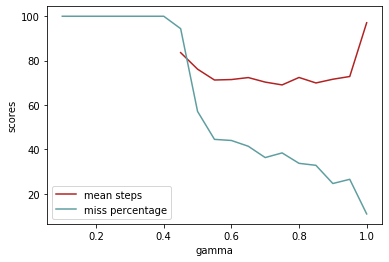

In [40]:
plot_graphs(vi_gamma_list, scores_test_vi_gamma, ["mean steps", "miss percentage"], param_name="gamma", curve_name="scores")

In [41]:
vi_eps_list = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
l_vi_eps_list = len(vi_eps_list)

# vi_mean_steps, vi_per_misses
scores_test_vi_eps = np.zeros((2, l_vi_eps_list))
for i in range(l_vi_eps_list):
    vi_state_values = np.zeros(n_state)
    vi_state_values = value_iteration(max_iterations=100000, eps=vi_eps_list[i], gamma=0.9)
    vi_policy = get_policy(vi_state_values)
    scores_test_vi_eps[:, i] = get_scores(vi_policy, episodes=1000)

max iter: 100000 gamma: 0.9 , conv iter: 11 , conv time: 0.04292702674865723
max iter: 100000 gamma: 0.9 , conv iter: 18 , conv time: 0.06662130355834961
max iter: 100000 gamma: 0.9 , conv iter: 35 , conv time: 0.11722970008850098
max iter: 100000 gamma: 0.9 , conv iter: 42 , conv time: 0.14623475074768066
max iter: 100000 gamma: 0.9 , conv iter: 56 , conv time: 0.19108295440673828
max iter: 100000 gamma: 0.9 , conv iter: 62 , conv time: 0.21381092071533203
max iter: 100000 gamma: 0.9 , conv iter: 75 , conv time: 0.2602114677429199


In [52]:
scores_test_vi_eps

array([[83.47619048, 70.32160804, 70.90317919, 70.48787062, 72.77520436,
        74.96419098, 72.33641161],
       [95.8       , 40.3       , 30.8       , 25.8       , 26.6       ,
        24.6       , 24.2       ]])

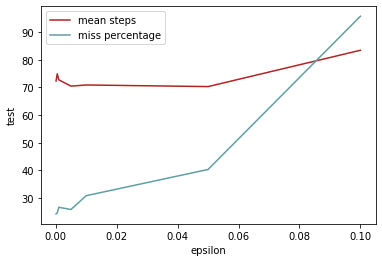

In [42]:
plot_graphs(vi_eps_list, scores_test_vi_eps, ["mean steps", "miss percentage"], param_name="epsilon", curve_name="test")